# 00000: Georeference
Authors: Tobias G. Mueller, Mark A. Buckner
Last modified: 4 Dec 2024
Contact: __________

**Summary**: Here, we georeference the model predictions and orthomosaic


This script outputs 
- a georeference raster (EPSG 32618) in tif format
- a list of coordinates (EPSG 32618) of each nest centroid in csv format

The data used in this script was generated in:
    `AIggregation/notebooks/03_validation_and_optimization.ipynb`



In [24]:
# Imports
import os
import rasterio
from rasterio.plot import show
import numpy as np
import csv
import pandas as pd
import glob

# first check the wd is not notebooks but the main folder
print("cwd is", os.getcwd())

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("cwd changed to", os.getcwd())





cwd is /home/tmueller/github/AIggregation


Before we can georeference the model predictions we need to input our ground control points. These consist of a series of matched sets of pixels coordinates in the image, and corresponding real world coordinate. A minimum of 3 GCP are required, however, 5 or more are recommended.

Here we are using EPSG 32618 (WGS84 18N)

In [25]:
# set paths and create GCPs

# -------------------------------------------------------------------------------------------------------------------- #
full_export_directory = "datasets/export_predictions/final"     # directory to optimized model output in yolov5 format
img_ext = ".png"                                                # image type predicted on
outputPath = "datasets/geo_outputs"                             # directory for georeferenced outputs
# -------------------------------------------------------------------------------------------------------------------- #


# NE corner of Holford plaque
gcp1 = rasterio.control.GroundControlPoint(col = 10304, row=1761, x=379256.53700, y=4699478.52032)

# NE corner of Brooks plaque
gcp2 = rasterio.control.GroundControlPoint(col = 21997, row=7147, x=379262.19952, y=4699478.42842)

# NE corner of Mabee plaque
gcp3 = rasterio.control.GroundControlPoint(col = 21015, row=916, x=379260.699480, y=4699480.76311)

# NE corner of margorie mabee plaque
gcp4 = rasterio.control.GroundControlPoint(col = 28347,row=275, x=379263.53480, y=4699482.32240)

# Stalk of pinecone SW of image
gcp5 = rasterio.control.GroundControlPoint(col = 3379, row=9200, x=379255.0672, y=4699474.2969)


Using the GCPs we can transform the raster and detections and output the georeferenced raster and nest detection centroids. Theses products can then be used in post analyses

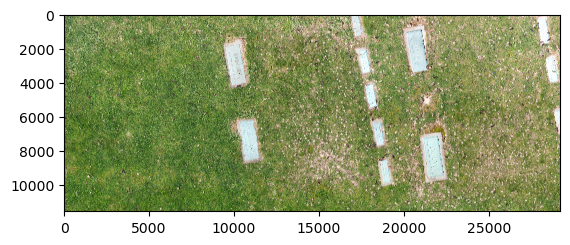

image pixel dimensions are:
(11552, 29184)
 
affine transformation:
| 0.00, 0.00, 379252.08|
| 0.00,-0.00, 4699477.40|
| 0.00, 0.00, 1.00|
[1.89738025e+04 2.30889824e+02 1.00000000e+00]
[2.38703816e+04 1.04362154e+04 1.00000000e+00]
[2.52995512e+04 1.07542420e+04 1.00000000e+00]
[1.2082176e+04 8.7396656e+03 1.0000000e+00]
[2.24579343e+04 2.62564253e+03 1.00000000e+00]
[2.84009933e+04 7.55625562e+03 1.00000000e+00]
[1.69403489e+04 1.09307681e+04 1.00000000e+00]
[2.54685266e+04 8.92368896e+02 1.00000000e+00]
[1.25078538e+04 1.08694154e+04 1.00000000e+00]
[1.60680684e+04 5.65915152e+03 1.00000000e+00]
[1.65866097e+04 4.32646659e+03 1.00000000e+00]
[1.89699210e+04 4.60808125e+03 1.00000000e+00]
[1.95121597e+04 6.95512419e+03 1.00000000e+00]
[2.57757174e+04 1.04143706e+04 1.00000000e+00]
[2.41711811e+04 1.10482866e+04 1.00000000e+00]
[1.49550198e+04 5.90656070e+03 1.00000000e+00]
[1.90128799e+04 2.56975395e+03 1.00000000e+00]
[1.62922015e+04 3.20725107e+03 1.00000000e+00]
[1.62313236e+04 3.

/tmp/ipykernel_182318/1194330951.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centers['z'] = 1 #add a z value since affine is a 3x3 matrix


In [ ]:
# open the ungeoreferenced image as a raster
unRefRaster = rasterio.open(glob.glob(f"{full_export_directory}/**/*{img_ext}", recursive=True)[0])
unRefRaster


# view raster
show(unRefRaster)

# print raster shape to adjust detection points to pixel coordinates
print("image pixel dimensions are:")
print(unRefRaster.read(1).shape)

# save image dimensions
imgwidth = unRefRaster.read(1).shape[1]
imgheight = unRefRaster.read(1).shape[0]

# save list of selected gcps
gcp = [gcp1, gcp2, gcp3, gcp4, gcp5]

# calculate required affine transformation using gcps
transformation = rasterio.transform.from_gcps(gcp)
print(" ")
print("affine transformation:")
print(transformation)


# set output file name
rasterpath = os.path.join(outputPath, "georef_raster.tif")

# create output folder if it doesnt exist
if not os.path.exists(outputPath):
    os.makedirs(outputPath)


# create raster and write bands using the transformation and crs 
with rasterio.open(
    rasterpath, # specify output raster file path
    'w', # 'w' to specify writing mode
    driver='GTiff', #name of deisred format driver
    height=unRefRaster.read(1).shape[0], #height, in this case taken from unreferenced raster
    width=unRefRaster.read(1).shape[1], #width, in this case taken from unreferenced raster
    count=3, # how many dataset bands (3 for standard color)
    dtype=unRefRaster.read(1).dtype, #data type of dataset
    crs=rasterio.crs.CRS.from_epsg(32618), #CRS.  (WGS84 18N)
    transform=transformation, # specify affine transformation to be used
    ) as dst: # write out bands
    dst.write(unRefRaster.read(1), 1)
    dst.write(unRefRaster.read(2), 2)
    dst.write(unRefRaster.read(3), 3)


# now use the same transformation to adjust detections to georef them aswell


# read in detection bounding boxes
labels_txt = glob.glob(f"{full_export_directory}/**/*.txt", recursive=True)[0]

# convert into csv
labels = pd.read_csv(labels_txt, sep=' ',  names=['class', 'x', 'y', 'w', 'h', 'conf'])

#rescale detections from 0-1 (yolov5 format) to pixel coordinates
labels[['x', 'w']] = labels[['x', 'w']] * imgwidth
labels[['y', 'h']] = labels[['y', 'h']] * imgheight

# save just x and y and add a third column "z" to make a 3x3 matrix
centers = labels[['x','y']]
centers['z'] = 1 #add a z value since affine is a 3x3 matrix

# change from type affine to array
tmatrix=  np.array(transformation)

# and specify matrix shape
tmatrix.shape = (3,3)


export_georef_centroids = os.path.join(outputPath, "georef_centroids.csv")

# multiply csv rows by affine matrix and save
with open(export_georef_centroids, 'w', newline='') as output:
  writer = csv.writer(output)
  writer.writerow(['x','y','z'])
  for index, row in centers.iterrows():
    mrow = np.array(row)
    newxy = np.dot(tmatrix,mrow)
    writer.writerow(newxy)